In [1]:
!pip install tensorflow-gpu==2.1.0
!pip install tensorflow-addons

In [2]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import matplotlib.pyplot as plt

TensorFlow version: 2.1.0
Num GPUs Available:  1


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
work_path = "/content/gdrive/My Drive/tinkoffCV"

df = pd.read_csv(os.path.join(work_path, "data/face_labels.csv"))
df.head()

,path,label
0,./data/images/faces/89_2.jpeg,1
1,./data/images/faces/23_1.jpeg,0
2,./data/images/faces/20_0.jpeg,0
3,./data/images/faces/61_0.jpeg,0
4,./data/images/faces/152_0.jpeg,0


In [0]:
paths, labels = df.values[:, 0], np.array(df.values[:, 1], dtype=np.uint8)
paths = np.array(list(map(lambda path: os.path.join(work_path, path[2:]), paths)))

# Create dataset

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def load_img(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    return tf.image.resize_with_pad(img, 32, 32), label

def augmentation(img, label):
    img = tf.image.random_flip_left_right(img)
    
    return img, label

def create_dataset(paths, labels, trainable=True, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_img, num_parallel_calls=AUTOTUNE)
    
    if trainable:
        dataset = dataset.shuffle(len(paths))
        dataset = dataset.map(augmentation, num_parallel_calls=AUTOTUNE)
    
    return dataset.batch(batch_size)

In [0]:
train_ds = create_dataset(paths, labels)

# Define model

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, padding="same", activation="relu", input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None),
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          4

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tfa.losses.TripletSemiHardLoss())

# Train model

In [10]:
history = model.fit(train_ds, epochs=1000,
                    callbacks=[tf.keras.callbacks.TensorBoard(os.path.join(work_path, "encoder/log")),
                               tf.keras.callbacks.ModelCheckpoint(os.path.join(work_path, "encoder/model_x64_x32_x16_256.h5"),
                                                                  monitor="loss", verbose=1, save_best_only=True)])

Train for 18 steps
Epoch 1/1000
11/18 [=================>............] - ETA: 51s - loss: 0.9819 
Epoch 00001: loss improved from inf to 0.98250, saving model to /content/gdrive/My Drive/tinkoffCV/encoder/model_x64_x32_x16_256.h5
18/18 [==============================] - 81s 4s/step - loss: 0.9863
Epoch 2/1000
15/18 [========================>.....] - ETA: 0s - loss: 0.9666
Epoch 00002: loss did not improve from 0.98250
18/18 [==============================] - 1s 45ms/step - loss: 1.0172
Epoch 3/1000
 9/18 [==============>...............] - ETA: 0s - loss: 0.9474 
Epoch 00003: loss improved from 0.98250 to 0.95321, saving model to /content/gdrive/My Drive/tinkoffCV/encoder/model_x64_x32_x16_256.h5
18/18 [==============================] - 1s 45ms/step - loss: 0.9501
Epoch 4/1000
14/18 [======================>.......] - ETA: 0s - loss: 0.9377
Epoch 00004: loss improved from 0.95321 to 0.93550, saving model to /content/gdrive/My Drive/tinkoffCV/encoder/model_x64_x32_x16_256.h5
18/18 [======

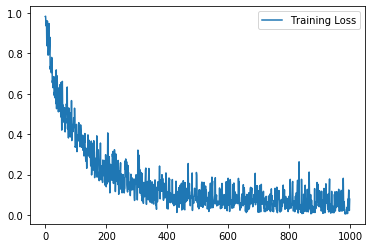

In [11]:
loss = history.history['loss']

plt.plot(range(1000), loss, label='Training Loss')
plt.legend(loc='upper right')
plt.show()

# Encoding images

In [0]:
encoder = tf.keras.models.load_model(os.path.join(work_path, "encoder/model_x64_x32_x16_256.h5"), compile=False)

encoder.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                   loss=tfa.losses.TripletSemiHardLoss())

In [0]:
ds = create_dataset(paths, labels, trainable=False)

labels = []
for x, y in ds:
    labels += list(y.numpy())

embeddings = encoder.predict(ds)

In [0]:
np.save(os.path.join(work_path, "encoder/embeddings.npy"), embeddings)
np.save(os.path.join(work_path, "encoder/labels.npy"), np.array(labels, dtype=np.uint8))